RNN - Erro dos pesos computados e usado somente durante a iteração

In [2]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import operator as op
import matplotlib.pyplot as plt
import math
import time
from Utils99 import *
from CLOUD import *
from TEDA import *
#from TEDA2 import *
from RLS_VDF import *
from RLS_LOG import *
from RLS_EXP import *
from Utils_graph import *
import optuna
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_pareto_front
from optuna.importance import get_param_importances
from optuna.samplers import RandomSampler
import sys
from TedaGraphs import *


def brng_params(brng):
    if brng == 'Bearing1_1.csv': Mp = [5, 18, 1.4476094320666959e-05, 2.4994589695113715e-05, 0.000113021531828127, 10, 1.26, 0.99]
    if brng == 'Bearing1_2.csv': Mp = [5, 18, 0.0011587259603807196, 0.00022711225579341771, 0.0005003578521059077, 7, 1.34, 0.98]
    if brng == 'Bearing1_3.csv': Mp = [5, 18, 0.00029985760409049995, 3.251063081814307e-05, 0.0001230888199580327, 12, 1.34, 0.96]
    if brng == 'Bearing2_2.csv': Mp = [5, 24, 0.0006826086663470173, 4.040452823742237e-05, 0.0007316593705663688, 18, 1.3599999999999999, 0.96]
    if brng == 'Bearing2_4.csv': Mp = [5, 15, 0.004268234559619661, 0.0002719800427134719, 0.0014263483063038727, 23, 1.3, 0.99]
    return Mp

c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Bearing1_1 - Erro: 226.23188206798926 parameters:  [17, 14, 1e-05, 0.0001, 1e-05, 12.0, 1.6, 0.3, 0.98]

In [6]:
j=3
brngs = ['Bearing1_1.csv','Bearing1_2.csv','Bearing1_3.csv','Bearing2_2.csv','Bearing2_4.csv']
names = ['B1_1','B1_2','B1_3','B2_2','B2_4']
brng = brngs[j]

p_rs, p_hi = 'RS/' + brng, 'HI/' + brng
df1, df2 = pd.read_csv(p_rs), pd.read_csv(p_hi)
RS = df1['RS'].values
HI = df2['PC1'].values
def objective(trial):
    nI=5
    nR = 18
    N1 = trial.suggest_float('N1', 1e-5, 1e-3, log=True)
    N2 = trial.suggest_float('N2', 1e-5, 1e-3, log=True)
    N3 = trial.suggest_float('N3', 1e-5, 1e-3, log=True)
    tau = trial.suggest_int('tau', 20, 27)
    m = trial.suggest_float('m', 1.24, 1.28, step=0.01)
    fator = trial.suggest_float('fator', 0.95, 0.99, step=0.01)
    nI = 5
    nR = 18
    X = np.array([RS[i:i+nI] for i in range(len(RS)-(nI-1))])
    Y = np.array([HI[i:i+nI] for i in range(len(HI)-(nI-1))])
    xS = X[1:]
    yS = Y[:-1]
    zS = Y[1:]

    teda = TEDARegressor(nI, nR, nI, N1, N2, N3, tau, m, 0.3, fator, ep=0.1, wta=False)

    for i in range(len(xS)):
        x, y, z = xS[i], yS[i], zS[i]
        teda.run(x)
        teda.adapt(y, z)
        teda.RUL_single(y)

        if i ==45:  # checkpoint de avaliação
            trial.report(teda.rulP[-1], step=i)
            if trial.should_prune():
                raise optuna.TrialPruned()

    return teda.MAPE()

study = optuna.create_study(direction="minimize",storage="sqlite:///"+"BEARINGS3.db",study_name=names[j]+'_R3',
                            load_if_exists=True,sampler=optuna.samplers.CmaEsSampler(restart_strategy ='ipop',inc_popsize =1,n_startup_trials=1000),
                            pruner=optuna.pruners.ThresholdPruner(lower=2,upper=159),
                    
                            )

study.optimize(objective, n_trials=5000,)

best_params = study.best_params
Mp = [5]+list(best_params.values())
print(brng[:-4], '- Erro:', study.best_value, 'parameters: ', Mp)

c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\samplers\_cmaes.py:269: FutureWarning:

`restart_strategy` has been deprecated in v4.4.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.4.0. From v4.4.0 onward, `restart_strategy` automatically falls back to `None`. `restart_strategy` will be supported in OptunaHub.

[I 2025-06-30 18:39:51,835] A new study created in RDB with name: B2_2_R3
[I 2025-06-30 18:39:52,376] Trial 0 pruned. 
[I 2025-06-30 18:39:52,764] Trial 1 pruned. 
[I 2025-06-30 18:39:53,115] Trial 2 pruned. 
[I 2025-06-30 18:39:53,558] Trial 3 pruned. 
[I 2025-06-30 18:39:53,981] Trial 4 pruned. 
[I 2025-06-30 18:39:54,363] Trial 5 pruned. 
[I 2025-06-30 18:39:54,737] Trial 6 pruned. 
[I 2025-06-30 18:39:55,117] Trial 7 pruned. 
[I 2025-06-30 18:39:55,967] Trial 8 pruned. 
[I 2025-06-30 18:39:56,545] Trial 9 pruned. 
[I 2025-06-30 18:39:57,138] Trial 10 pruned. 
[I 2025-06-30 18:39:57,577] Trial 1

ValueError: Record does not exist.

Bearing1_1 - Erro: 518.241307569085 parameters:  [5, 24, 4.6575317621958215e-05, 0.00010177377188548301, 0.0.00023187938521582915, 15, 1.24, 0.99]\
Bearing1_1 - Erro: 528.7138111915758 parameters:  [5, 16, 4.489632563983245e-05, 0.00014145468159031032, 0.00035596613501076677, 25, 1.26, 0.96]\
Bearing1_1 - Erro: 398.78344124640324 parameters:  [5, 18, 1.4476094320666959e-05, 2.4994589695113715e-05, 0.000113021531828127, 10, 1.26, 0.99]\
\
Bearing1_2 - Erro: 643.935757324285 parameters:  [5, 18, 0.0011587259603807196, 0.00022711225579341771, 0.0005003578521059077, 7, 1.34, 0.98]\
Bearing1_2 - Erro: 643.6075521960802 parameters:  [5, 18, 0.0011587207750513768, 0.00022705805815991244, 0.0005003348427694104, 7, 1.3, 0.98]\
Bearing1_2 - Erro: 629.9542364705932 parameters:  [5, 18, 0.001152639089974301, 0.00022699592183271605, 0.0004899724732771622, 7, 1.38, 0.98]\

\
Bearing1_3 - Erro: 114.10151891386829 parameters:  [5, 18, 0.00029985760409049995, 3.251063081814307e-05, 0.0001230888199580327, 12, 1.34, 0.96]\
Bearing2_2 - Erro: 577.4032342797062 parameters:  [5, 24, 0.0006826086663470173, 4.040452823742237e-05, 0.0007316593705663688, 18, 1.3599999999999999, 0.96]\
Bearing2_4 - Erro: 22.417090598923973 parameters:  [5, 15, 0.004268234559619661, 0.0002719800427134719, 0.0014263483063038727, 23, 1.3, 0.99]

In [1]:
brng = 'Bearing2_2.csv'
p_rs, p_hi = 'RS/'+brng, 'HI/'+brng
df1, df2 = pd.read_csv(p_rs), pd.read_csv(p_hi)
RS = df1['RS'].values
HI = df2['PC1'].values

nI,nR,N1,N2,N3,tau,m,fator = brng_params(brng)
#nI,nR,N1,N2,N3,tau,m,fator = Mp

X = np.array([RS[i:i+nI] for i in range(len(RS)-(nI-1))])
Y = np.array([HI[i:i+nI] for i in range(len(HI)-(nI-1))])
xS = X[1:]
yS = Y[:-1]
zS = Y[1:]

teda = TEDARegressor(nI,nR,nI,N1,N2,N3,tau,m,0.3,fator,ep=0.077,wta=False)

for i in range(len(xS)):
    x,y,z = xS[i],yS[i],zS[i]
    teda.run(x)
    teda.adapt(y,z)
    teda.RUL_uncertainty(y)

print('granules qtd:',teda.g,'granules total:',len(teda.c) ,'MAPE:',teda.MAPE(),'MAPE2:',teda.MAPE2())
name = 'Bearing1_1'
plot_RUL_CI(teda,startX=0,endX=165,endY=165,startY=-1,lw1=1.5,lw2=2,name=None)
plot_HI(teda,name=name)
plot_DSI(teda,name=name)


NameError: name 'pd' is not defined

In [ ]:
brng = 'Bearing1_3.csv'
p_rs, p_hi = 'RS/' + brng, 'HI/' + brng
df1, df2 = pd.read_csv(p_rs), pd.read_csv(p_hi)
RS = df1['RS'].values
HI = df2['PC1'].values

def objective(trial):

    nI,nR,N1,N2,N3,tau,m,fator = brng_params(brng)
    ep = trial.suggest_float('ep', 0.001, 1, step=0.001)

    X = np.array([RS[i:i+nI] for i in range(len(RS)-(nI-1))])
    Y = np.array([HI[i:i+nI] for i in range(len(HI)-(nI-1))])
    xS = X[1:]
    yS = Y[:-1]
    zS = Y[1:]

    teda = TEDARegressor(nI, nR, nI, N1, N2, N3, tau, m, 0.3, fator, ep)

    for i in range(len(xS)):
        x, y, z = xS[i], yS[i], zS[i]
        teda.run(x)
        teda.adapt(y, z)
        teda.RUL_uncertainty(y)

    score = teda.specificity()*teda.coverage()

    if i % 10 == 0:  # checkpoint de avaliação
            trial.report(score, step=i)
            if trial.should_prune():
                raise optuna.TrialPruned()
            
    return score

study = optuna.create_study(direction="maximize",storage="sqlite:///"+'Granularity'+".db",study_name=brng[:-4]+'P2',
                            load_if_exists=True,
                            sampler=optuna.samplers.RandomSampler()
                            )
study.optimize(objective, n_trials=10000)

best_params = study.best_params
Mp = list(best_params.values())
print("\n🔹 Melhor Configuração Encontrada:")
print(brng[:-4], '- Erro:', study.best_value, 'parameters: ', Mp)

Bearing1_1 - Erro: 0.5505970002940888 parameters:  [0.137]\
Bearing1_2 - Erro: 0.15093640762089958 parameters:  [0.1]\
Bearing1_3 - Erro: 0.3281329975636222 parameters:  [0.046]\
Bearing2_2 - Erro: 0.32701118568232657 parameters:  []\
Bearing2_4 - Erro: 0.7180020811654525 parameters:  []\



{'nR': 23, 'N1': 5.897667788129597e-05, 'N2': 5.527672444451778e-05, 'N3': 0.00047828383978105055, 'tau': 12, 'm': 1.25, 'fator': 0.97}. Best is trial 12 with value: 4800.519789411119.


MAPE: 577.4032342797062 spc: 0.9345413870246085 score: 0.40496793437733036


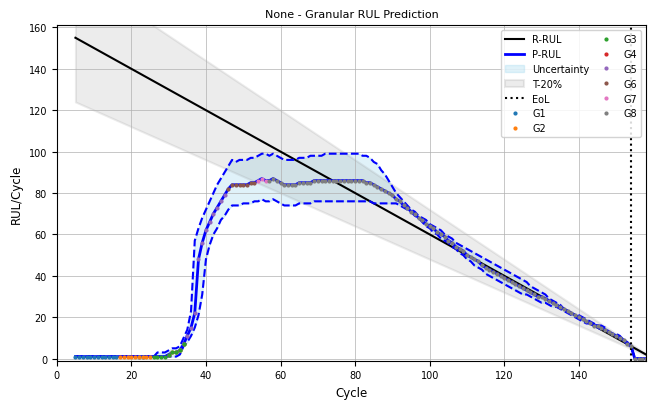

ID: 5 merge: G5: G1+G4 n samples: 37.0
ID: 6 merge: None n samples: 8
ID: 7 merge: None n samples: 3
ID: 8 merge: None n samples: 104


In [5]:
brng = 'Bearing2_2.csv'
p_rs, p_hi = 'RS/'+brng, 'HI/'+brng
df1, df2 = pd.read_csv(p_rs), pd.read_csv(p_hi)
RS = df1['RS'].values
HI = df2['PC1'].values

nI,nR,N1,N2,N3,tau,m,fator = brng_params(brng)

X = np.array([RS[i:i+nI] for i in range(len(RS)-(nI-1))])
Y = np.array([HI[i:i+nI] for i in range(len(HI)-(nI-1))])
xS = X[1:]
yS = Y[:-1]
zS = Y[1:]
teda = TEDARegressor(nI,nR,nI,N1,N2,N3,tau,m,0.3,fator,ep=0.046,wta=False)

for i in range(len(xS)):
    x,y,z = xS[i],yS[i],zS[i]
    teda.run(x)
    teda.adapt(y,z)
    teda.RUL_uncertainty(y)
    #print(i, teda.rulP[-1])

print('MAPE:',teda.MAPE(),'spc:',teda.specificity() ,'score:',teda.specificity()*teda.coverage())
name = ' '
plot_RUL_CI(teda,startX=0,endY=160,startY=-1,lw1=1.5,lw2=2,name=None)
#plot_HI(teda,name=name)
#plot_DSI(teda,name=name)
for c in teda.c:
    print('ID:',c.ID,'merge:',c.merge,'n samples:',c.n)


In [9]:
teda.rulP

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
        3.,  3.,  4.,  7., 11., 15., 22., 48., 56., 62., 66., 70., 73.,
       76., 79., 82., 84., 84., 84., 84., 84., 85., 85., 86., 87., 86.,
       86., 87., 86., 85., 84., 84., 84., 84., 85., 85., 85., 85., 86.,
       86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
       85., 85., 84., 83., 82., 81., 80., 79., 77., 76., 74., 73., 71.,
       70., 68., 67., 65., 64., 63., 61., 60., 59., 57., 56., 54., 53.,
       52., 50., 49., 48., 47., 45., 44., 43., 42., 41., 40., 39., 38.,
       37., 36., 35., 34., 33., 32., 31., 30., 30., 29., 28., 27., 26.,
       25., 24., 23., 22., 21., 20., 19., 18., 17., 16., 16., 15., 14.,
       13., 12., 11., 10.,  9.,  7.,  6.,  0.,  0.,  0.,  0.,  0.,  0.])

MAPE: 10971.661989711654 spc: 0.8135406048250085 score: 0.029854701094495725


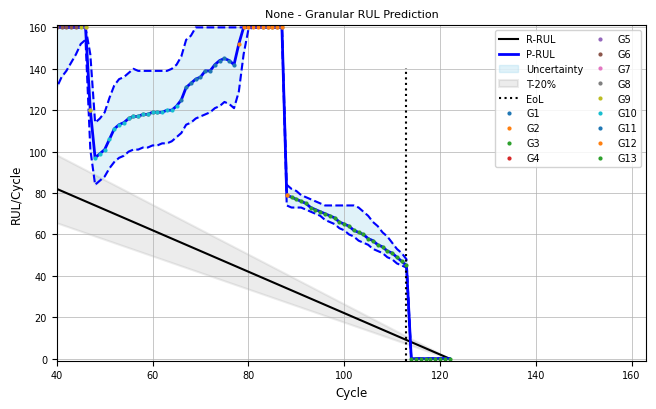

In [ ]:
brng = 'Bearing1_1.csv'
p_rs, p_hi = 'RS/'+brng, 'HI/'+brng
df1, df2 = pd.read_csv(p_rs), pd.read_csv(p_hi)
RS = df1['RS'].values
HI = df2['PC1'].values

X = np.array([RS[i:i+nI] for i in range(len(RS)-(nI-1))])
Y = np.array([HI[i:i+nI] for i in range(len(HI)-(nI-1))])
xS = X[1:]
yS = Y[:-1]
zS = Y[1:]

for i in range(len(xS)):
    #print('iteration: ', i)
    x,y,z = xS[i],yS[i],zS[i]
    teda.run(x)
    teda.adapt(y,z)
    teda.RUL_uncertainty(y)
    #for c in teda.c:
    #    print(c.n)

print('MAPE:',teda.MAPE(),'spc:',teda.specificity() ,'score:',teda.specificity()*teda.coverage())
name = ' '
plot_RUL_CI(teda,startX=40,endX=160,endY=160,startY=-1,lw1=1.5,lw2=2,name=None)
#plot_HI(teda,name=name)
#plot_DSI(teda,name=name)
#teda.TransferLearning()

In [ ]:
len(teda.c)

8

In [ ]:
for c in teda.c:
    print('ID:',c.ID,'merge:',c.merge,'n samples:',c.n)

ID: 1 merge: None n samples: 16
ID: 2 merge: None n samples: 39
ID: 11 merge: None n samples: 31.0
ID: 4 merge: None n samples: 11
ID: 19 merge: None n samples: 57.0
ID: 16 merge: G16: G15+G8 n samples: 155.0
ID: 17 merge: G19: G13+G18 n samples: 3
ID: 20 merge: None n samples: 1
